# Transfer learning и ResNet
 В этот раз мы продолжим работать с изображениями с помощью нейронных сетей. В этот раз мы обсудим, как адаптировать уже существующие обученные модели для своих задач

План:
- ResNet
- transfer learning и fine-tuning
- Визуализация модели
- Torchmetrics, scheduler, ???

In [1]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
import tqdm
import matplotlib
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

%matplotlib inline
warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
from utils.common import seed_everything
seed_everything(123)

In [3]:
DATA_PATH = "C:\\Users\\tosha\\PycharmProjects\\spbu_deep_learning\\homeworks\\genshin"

In [4]:
dataset = ImageFolder(
    DATA_PATH,
    transform=Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1))
        ]
    ),
)

from torch.utils.data.dataloader import default_collate

train_set, val_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True,
                                               collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False,
                                             collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

*Задание*: выведите случайный элемент датасета

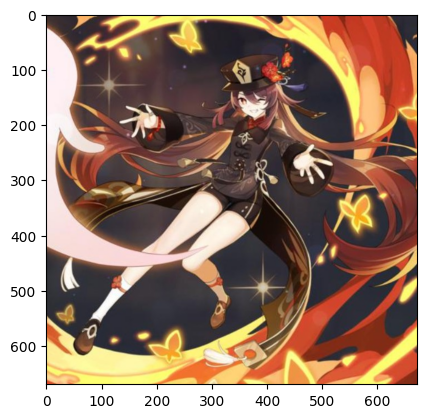

In [7]:
folder= np.random.choice(['Albedo', 'Ayaka', 'Hu Tao', 'Kokomi', 'Neither'])
file = np.random.choice(glob.glob(f'{DATA_PATH}/{folder}/*.*'))
img = matplotlib.image.imread(file)
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..0.5].


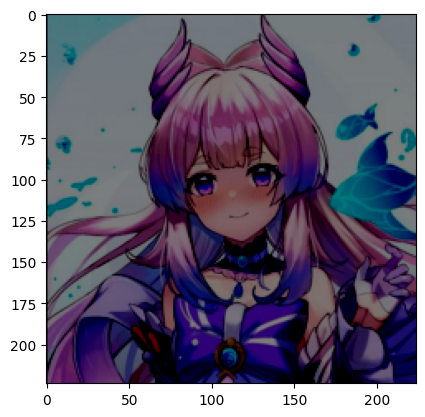

In [8]:
# выведите 352 семпл
plt.imshow(dataset[352][0].permute(1, 2, 0))
plt.show()

Тут мы сталкиваемся с двумя проблемами сразу:
- датасет очень маленький, и собирать его руками достаточно сложно
- если мы попробуем обучить какую-то модель с нуля, это может занять очень много времени

К тому же, наши картинки еще довольно похожи на стандартные изображения. Поэтому можно попытаться как-то перенести уже полученные знания какой-то крутой модели на свою задачу.
Чаще всего для этого ипользуется файн-тюнинг.

Идея у него проста: модель, когда-то обученная на большом датасете, уже умеет выделять какие-то хорошие признаки из входных данных, поэтому мы можем взять ее веса и немного поменять их, чтобы она лучше понимала новую задачу.


## ResNet
Исследователи заметили, что когда речь идет о сверточных нейронных сетях, чем модель глубже, тем лучше. Это имеет смысл, потому что их гибкость в адаптации к любому пространству увеличивается с увеличением числа параметров). Однако было замечено, что начиная с некоторй глубины, точность перестает увеличиваться, а наоборот, начинает падать.
*Вопрос:* с чем связано это явление?

Так появилось семейство ResNet. Идея проста: еслт модель может предсказать $f(x)$, то может предсказать и $f(x) - x$.
Это очень полезно, так как позволяет улучшить обучаемость моделей. (Чем?)
![alt_text](../additional_materials/images/resnet.png)

В модели это реализовано следующим образом: к выходу слоя можно добавить его же вход (что распространяется и на более длинные связи).

Обычный блок выглядит примерно следующим образом:

Input: x

[Conv 3x3]
[Batch Normalization]
[Activation (e.g., ReLU)]
[Conv 3x3]
[Batch Normalization]

Add: x + F(x) (Output from the above layers)
[Activation (e.g., ReLU)]


Глубокие варианты используют не двухслойные блоки, но также и bottleneck блоки, которые состоят из трех сверточных слоев следующего вида:

[Conv 1x1]
[BN + ReLU]
[Conv 3x3]
[BN + ReLU]
[Conv 1x1]
[BN]

*Вопрос*: Почему используются блоки 3x3?
*Вопрос 2*: А почему по два таких слоя в блоке, а не один?


В библиотеке torchvision имплементировано не только большое множество моделей (всевозможные ResNet'ы, Inception, VGG, AlexNet, DenseNet, ResNext, WideResNet, MobileNet...), но и загружены чекпоинты обучения этих моделей на ImageNet.

In [9]:
from torchvision.models import resnet18

In [10]:
model = resnet18(pretrained=True)

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Transfer learning
В задаче transfer learning'a последний слой нейросети заменяется на линейный с нужным числом выходов, а веса остальных слоёв "замораживаются".
Иногда делают полный файнтюн, тогда основные веса тоже обучаются, но в таком случае нужно задавать очень маленькие значения скорости обучения, чтобы не забыть то, что модель выучила раньше

Задание: определите, сколько классов в нашем датасете

In [12]:
print(f'{len(dataset.class_to_idx)} classes')
dataset.class_to_idx

5 classes


{'Albedo': 0, 'Ayaka': 1, 'Hu Tao': 2, 'Kokomi': 3, 'Neither': 4}

Теперь научимся загружать веса нашей модели, а также переделывать ее под свои нужды.

In [13]:
def get_model(
        pretrained: bool = True, num_out_classes: int=10
):
    if pretrained:
        model = resnet18(pretrained=True)
        # freeze parameters of original model
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_out_classes)
    else:
        model = resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_out_classes)
    return model


Проверим нашу функцию

In [14]:
model = get_model(pretrained=True, num_out_classes=5).to(device)

In [15]:
# Проверьте, задан ли градиент у какого-нибудь слоя из тела модели (это все, что не голова)

next(model.layer1[0].conv1.parameters())[0].requires_grad
# градиента нет

False

In [16]:
loss = torch.nn.CrossEntropyLoss()

В этом ноутбуке мы рассмотрим еще очень полезную библиотеку, которая поможет нам считать метрики качества.

In [18]:
import torchmetrics
metric = torchmetrics.MetricCollection({
    'accuracy_micro': torchmetrics.Accuracy(task="multiclass", num_classes=5, average='micro').to(device),
    'accuracy_macro': torchmetrics.Accuracy(task="multiclass", num_classes=5, average='macro').to(device),
    'recall_micro': torchmetrics.Recall(task="multiclass", num_classes=5, average='micro').to(device),
    'recall_macro': torchmetrics.Recall(task="multiclass", num_classes=5, average='macro').to(device),
    'precision_micro': torchmetrics.Precision(task="multiclass", num_classes=5, average='micro').to(device),
    'precision_macro': torchmetrics.Precision(task="multiclass", num_classes=5, average='macro').to(device)
})

*Задание*: добавьте метрики Precision, recall.
*Задание 2*: сравните метрики с reduction=micro, macro. Ответьте, в чем разница и в каких ситуациях та или иная настройка лучше отражает качество предсказаний.

микро - глобально, например для acc - количество правильных / общее количество \
макро - среднее по классам, для acc - считаем acc отдельно для каждого класса и усредняем \
(аналогично с остальными метриками) \
микро предпочтительнее, если нам важнее в среднем давать правильный прогноз, но в таком случае возможно, для каких-то редких классов, 
все будет плохо, но метрика этого не покажет. \
макро предпочтительнее, если нам важно получить максимальную точность на каждом классе, не игнорируя даже редкие. В таком случае возможно, что метрика будет низкой из-за какого-то редкого проблемного класса, даже если для всех остальных классов модель дает отличные предсказания

Вспомним рутину: напишем обучающий цикл. Заполните функциии в нужных местах.

In [51]:
def train_epoch(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    metric: torchmetrics.Metric,
    optimizer: torch.optim.Optimizer,
    return_losses=False,
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm.tqdm(total=len(data_loader)) as prbar:
        for inputs, targets in data_loader:
            # train step: preds, loss, optimization, etc
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # update description for tqdm
            metrics = metric(preds, targets)
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy_micro: {round(metrics['accuracy_micro'].item(), 4)} "
                f"Accuracy_macro: {round(metrics['accuracy_macro'].item(), 4)} "
                f"Precision_micro: {round(metrics['precision_micro'].item(), 4)} "
                f"Precision_macro: {round(metrics['precision_macro'].item(), 4)} "
                f"Recall_micro: {round(metrics['recall_micro'].item(), 4)} "
                f"Recall_macro: {round(metrics['recall_macro'].item(), 4)} "
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = metric.compute()
    metrics = {f'{name}' : f'{metrics[name].item()}' for name in metrics.keys()}
    metrics['loss'] = total_loss / num_batches
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(
        model,
        data_loader,
        criterion,
        metric,
        device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm.tqdm(total=len(data_loader)) as prbar:
        for inputs, targets in data_loader:
            with torch.no_grad():
                preds = model(inputs)
                loss = criterion(preds, targets)
                total_loss += loss.item()
                metrics = metric(preds, targets)

            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy_micro: {round(metrics['accuracy_micro'].item(), 4)} "
                f"Accuracy_macro: {round(metrics['accuracy_macro'].item(), 4)} "
                f"Precision_micro: {round(metrics['precision_micro'].item(), 4)} "
                f"Precision_macro: {round(metrics['precision_macro'].item(), 4)} "
                f"Recall_micro: {round(metrics['recall_micro'].item(), 4)} "
                f"Recall_macro: {round(metrics['recall_macro'].item(), 4)} "
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    metrics = metric.compute()
    metrics = {f'{name}' : f'{metrics[name].item()}' for name in metrics.keys()}
    metrics['loss'] = total_loss / num_batches
    return metrics

Иногда удобно сохранять данные в определенном формате. Один из возможных вариантов - namedtuple. Он похволяет как сохранять порядок элементов, так и использовать более понятную индексацию

In [47]:
from collections import namedtuple

LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)
EPOCHS = 10
LR = 0.001

In [52]:
def train(model, epochs, train_data_loader, validation_data_loader,
          criterion, metric, optimizer, scheduler=None, device="cuda:0",):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            criterion=criterion,
            metric=metric,
            optimizer=optimizer,
            return_losses=True,
        )
        # save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # eval step
        print(f"Validation Epoch: {epoch}")

        # call function validation epoch and
        # save eval losses
        # <YOUR CODE>
        # scheduler step
        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

In [53]:
model = get_model(pretrained=True, num_out_classes=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [54]:
model
_ = train(
    model=model,
    epochs=15,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    criterion=loss,
    metric=metric,
    optimizer=optimizer,
    device=device,
)

Train Epoch: 0


Loss: 1.3318 Accuracy_micro: 0.4615 Accuracy_macro: 0.5833 Precision_micro: 0.4615 Precision_macro: 0.4333 Recall_micro: 0.4615 Recall_macro: 0.5833 : 100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Validation Epoch: 0
Train Epoch: 1


Loss: 1.3756 Accuracy_micro: 0.4615 Accuracy_macro: 0.6067 Precision_micro: 0.4615 Precision_macro: 0.6333 Recall_micro: 0.4615 Recall_macro: 0.6067 : 100%|██████████| 27/27 [00:05<00:00,  4.81it/s]


Validation Epoch: 1
Train Epoch: 2


Loss: 0.9537 Accuracy_micro: 0.5385 Accuracy_macro: 0.4167 Precision_micro: 0.5385 Precision_macro: 0.4167 Recall_micro: 0.5385 Recall_macro: 0.4167 : 100%|██████████| 27/27 [00:05<00:00,  4.75it/s]


Validation Epoch: 2
Train Epoch: 3


Loss: 0.4483 Accuracy_micro: 1.0 Accuracy_macro: 1.0 Precision_micro: 1.0 Precision_macro: 1.0 Recall_micro: 1.0 Recall_macro: 1.0 : 100%|██████████| 27/27 [00:05<00:00,  4.85it/s]                  


Validation Epoch: 3
Train Epoch: 4


Loss: 0.5855 Accuracy_micro: 0.9231 Accuracy_macro: 0.96 Precision_micro: 0.9231 Precision_macro: 0.9333 Recall_micro: 0.9231 Recall_macro: 0.96 : 100%|██████████| 27/27 [00:05<00:00,  4.85it/s]    


Validation Epoch: 4
Train Epoch: 5


Loss: 0.8036 Accuracy_micro: 0.7692 Accuracy_macro: 0.9 Precision_micro: 0.7692 Precision_macro: 0.7667 Recall_micro: 0.7692 Recall_macro: 0.9 : 100%|██████████| 27/27 [00:05<00:00,  4.81it/s]      


Validation Epoch: 5
Train Epoch: 6


Loss: 0.5246 Accuracy_micro: 0.7692 Accuracy_macro: 0.75 Precision_micro: 0.7692 Precision_macro: 0.88 Recall_micro: 0.7692 Recall_macro: 0.75 : 100%|██████████| 27/27 [00:05<00:00,  4.88it/s]      


Validation Epoch: 6
Train Epoch: 7


Loss: 0.1722 Accuracy_micro: 1.0 Accuracy_macro: 1.0 Precision_micro: 1.0 Precision_macro: 1.0 Recall_micro: 1.0 Recall_macro: 1.0 : 100%|██████████| 27/27 [00:05<00:00,  4.85it/s]                  


Validation Epoch: 7
Train Epoch: 8


Loss: 0.3937 Accuracy_micro: 1.0 Accuracy_macro: 1.0 Precision_micro: 1.0 Precision_macro: 1.0 Recall_micro: 1.0 Recall_macro: 1.0 : 100%|██████████| 27/27 [00:05<00:00,  4.84it/s]                  


Validation Epoch: 8
Train Epoch: 9


Loss: 0.2444 Accuracy_micro: 1.0 Accuracy_macro: 1.0 Precision_micro: 1.0 Precision_macro: 1.0 Recall_micro: 1.0 Recall_macro: 1.0 : 100%|██████████| 27/27 [00:05<00:00,  4.92it/s]                  


Validation Epoch: 9
Train Epoch: 10


Loss: 0.1011 Accuracy_micro: 1.0 Accuracy_macro: 1.0 Precision_micro: 1.0 Precision_macro: 1.0 Recall_micro: 1.0 Recall_macro: 1.0 : 100%|██████████| 27/27 [00:05<00:00,  4.81it/s]                  


Validation Epoch: 10
Train Epoch: 11


Loss: 0.4314 Accuracy_micro: 0.7692 Accuracy_macro: 0.8167 Precision_micro: 0.7692 Precision_macro: 0.75 Recall_micro: 0.7692 Recall_macro: 0.8167 : 100%|██████████| 27/27 [00:05<00:00,  4.84it/s]  


Validation Epoch: 11
Train Epoch: 12


Loss: 0.1518 Accuracy_micro: 1.0 Accuracy_macro: 1.0 Precision_micro: 1.0 Precision_macro: 1.0 Recall_micro: 1.0 Recall_macro: 1.0 : 100%|██████████| 27/27 [00:05<00:00,  4.80it/s]                  


Validation Epoch: 12
Train Epoch: 13


Loss: 0.2282 Accuracy_micro: 1.0 Accuracy_macro: 1.0 Precision_micro: 1.0 Precision_macro: 1.0 Recall_micro: 1.0 Recall_macro: 1.0 : 100%|██████████| 27/27 [00:05<00:00,  4.81it/s]                 


Validation Epoch: 13
Train Epoch: 14


Loss: 0.2467 Accuracy_micro: 1.0 Accuracy_macro: 1.0 Precision_micro: 1.0 Precision_macro: 1.0 Recall_micro: 1.0 Recall_macro: 1.0 : 100%|██████████| 27/27 [00:05<00:00,  4.82it/s]                 

Validation Epoch: 14


*Задание*: запустите обучение с использованием transfer learning и без него. В каком случае точность получилась выше?


In [55]:
model = get_model(pretrained=False, num_out_classes=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model
_ = train(
    model=model,
    epochs=5,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    criterion=loss,
    metric=metric,
    optimizer=optimizer,
    device=device,
)

Train Epoch: 0


Loss: 1.1647 Accuracy_micro: 0.4615 Accuracy_macro: 0.3524 Precision_micro: 0.4615 Precision_macro: 0.4333 Recall_micro: 0.4615 Recall_macro: 0.3524 : 100%|██████████| 27/27 [00:05<00:00,  4.57it/s]


Validation Epoch: 0
Train Epoch: 1


Loss: 1.0288 Accuracy_micro: 0.6154 Accuracy_macro: 0.65 Precision_micro: 0.6154 Precision_macro: 0.5167 Recall_micro: 0.6154 Recall_macro: 0.65 : 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]    


Validation Epoch: 1
Train Epoch: 2


Loss: 1.1554 Accuracy_micro: 0.4615 Accuracy_macro: 0.4133 Precision_micro: 0.4615 Precision_macro: 0.5467 Recall_micro: 0.4615 Recall_macro: 0.4133 : 100%|██████████| 27/27 [00:06<00:00,  4.39it/s]


Validation Epoch: 2
Train Epoch: 3


Loss: 1.036 Accuracy_micro: 0.4615 Accuracy_macro: 0.2667 Precision_micro: 0.4615 Precision_macro: 0.3 Recall_micro: 0.4615 Recall_macro: 0.2667 : 100%|██████████| 27/27 [00:06<00:00,  4.41it/s]    


Validation Epoch: 3
Train Epoch: 4


Loss: 1.7471 Accuracy_micro: 0.2308 Accuracy_macro: 0.3 Precision_micro: 0.2308 Precision_macro: 0.1833 Recall_micro: 0.2308 Recall_macro: 0.3 : 100%|██████████| 27/27 [00:06<00:00,  4.48it/s]     

Validation Epoch: 4


# Визуализация сети

Каждый слой в CNN изучает фильтры возрастающей сложности. На первых слоях выучиваются простые признаки, такие как края и углы. Средние слои обнаруживают части объектов — что касается лиц, они могут научиться реагировать на глаза и носы. Последние слои имеют более высокоуровневые представления: они учатся распознавать объекты целиком, в различных формах и положениях.

Мы попробуем проверить, так ли это, с помощью GradientExplainer, который использует ожидаемые градиенты для оценки входов в разные части модели. В целом, они аппроксимируют значения SHAP.

Возьмем по 50 семплов для подсчёта ожидаемых градиентов и посмотрим на признаки первых слоёв ResNet.

In [113]:
model.eval()
data = dataset[0]


In [114]:
dataset.classes

['Albedo', 'Ayaka', 'Hu Tao', 'Kokomi', 'Neither']

In [116]:
import shap
to_explain = torch.stack([dataset[0][0], dataset[123][0]], dim=0).to(device)
e = shap.GradientExplainer((model, model.layer1[0].conv2), to_explain)
# receive shap_values
shap_values, indexes = e.shap_values(
    to_explain, ranked_outputs=4, nsamples=50
)

# plot the explanations
#shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]


In [117]:
shap_values.shape

(2, 64, 56, 56, 4)

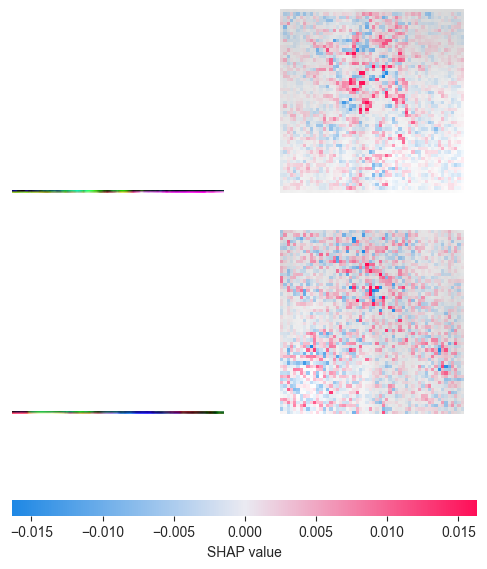

In [118]:
shap.image_plot(shap_values[0], to_explain.detach().cpu().numpy())

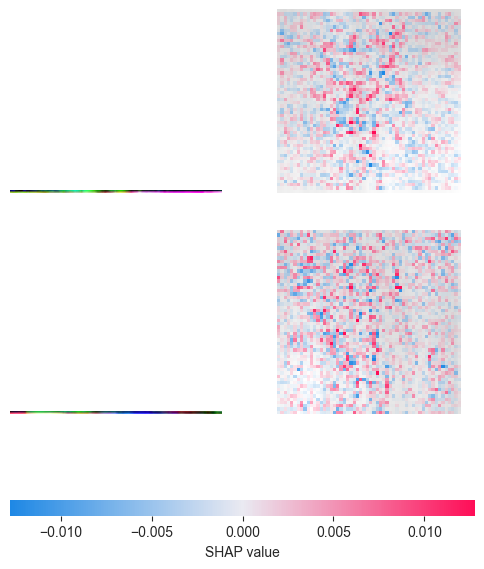

In [119]:
shap.image_plot(shap_values[1], to_explain.detach().cpu().numpy())

Повторите для второго слоя

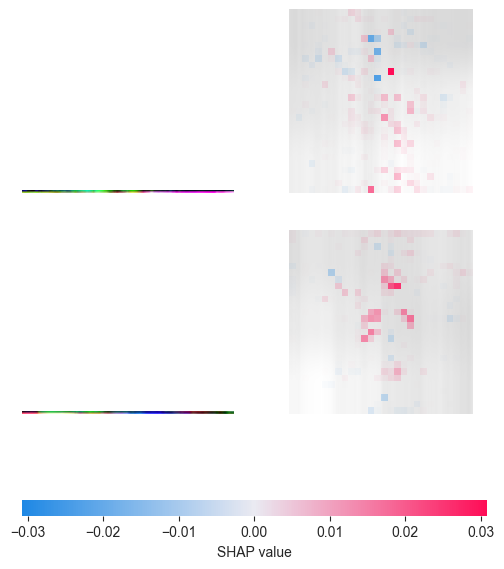

In [120]:
to_explain = torch.stack([dataset[0][0], dataset[123][0]], dim=0).to(device)
e = shap.GradientExplainer((model, model.layer2[0].conv2), to_explain)
# receive shap_values
shap_values, indexes = e.shap_values(
    to_explain, ranked_outputs=4, nsamples=50
)
shap.image_plot(shap_values[0], to_explain.detach().cpu().numpy())

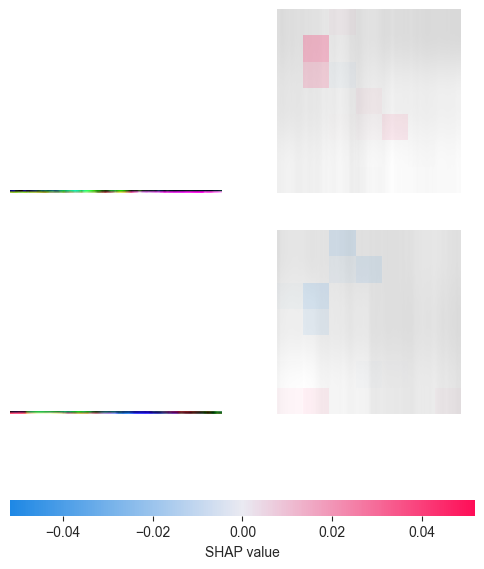

In [121]:
to_explain = torch.stack([dataset[0][0], dataset[123][0]], dim=0).to(device)
e = shap.GradientExplainer((model, model.layer4[0].conv2), to_explain)
# receive shap_values
shap_values, indexes = e.shap_values(
    to_explain, ranked_outputs=4, nsamples=50
)
shap.image_plot(shap_values[0], to_explain.detach().cpu().numpy())

Повторите для 4 слоя)

Но это не единственный способ заглянуть внутрь модели. Простейший вариант - оценить значения активаций на внутренних слоях. Можно было бы вывести веса, но они, к сожалению, не слишком интерпретируемы. Активации же показывают силу реакции конкретного фильтра.

Далее попробуем посмотреть на значения активаций при при проходе через изображение. В этом нам помогут хуки - эти функции позволяют получить доступ к состоянию между слоями (как входа, так и выхода слоя)
для визуализации, трансфер-лернинга, дебага модели итд.

In [122]:
activations = {}

# Function to create a hook
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# For example, let's hook into the first convolutional layer and the first block of layer1
model.conv1.register_forward_hook(get_activation('conv1'))
model.layer1[0].register_forward_hook(get_activation('layer1_block1'))


In [123]:
# Function to visualize feature maps
def visualize_feature_maps(activation, title, num_cols=8):
    num_feature_maps = activation.shape[0]
    num_rows = num_feature_maps // num_cols
    plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_feature_maps):

        if i >= num_cols * num_rows:
            break
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(activation[i].cpu().numpy(), cmap='coolwarm')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

#

Выведите значения активаций

In [125]:
# Perform a forward pass
with torch.no_grad():
    # прогоните модель для первого элемента датасета
    output = model(dataset[0][0].unsqueeze(0).to(device))


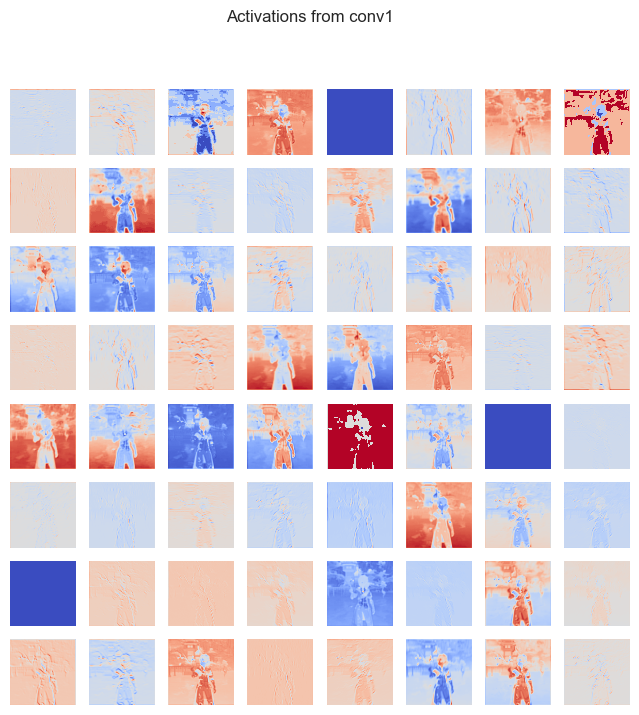

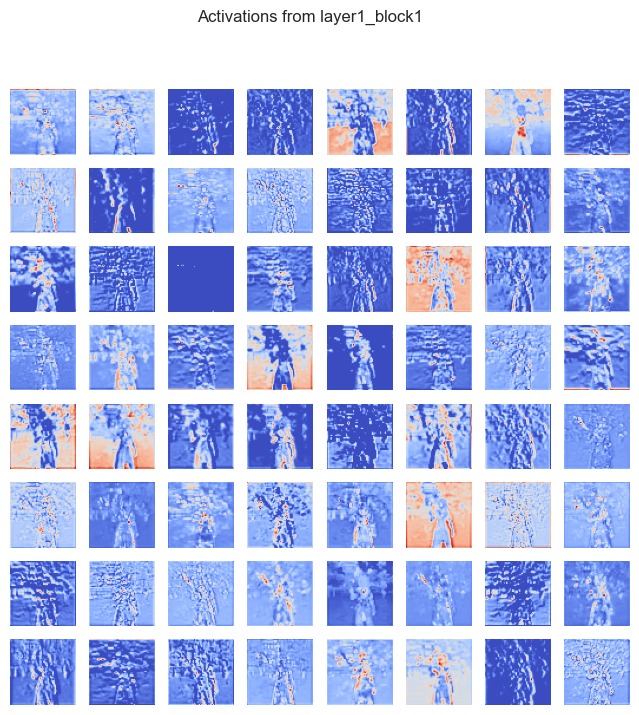

In [126]:
for name, activation in activations.items():
    # For convolutional layers, activation shape is (batch_size, num_channels, H, W)
    act = activation[0]
    act = act - act.min() # Почему нужно нормализовать?
    act = act / act.max()
    visualize_feature_maps(act, title=f'Activations from {name}')

In [ ]:
# попробуйте добавить хук и для 4 слоя. Какие значения у активаций? Похоже ли это на то, что мы видели для shap values?

In [130]:
activations = {}

# Function to create a hook
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# For example, let's hook into the first convolutional layer and the first block of layer1
model.conv1.register_forward_hook(get_activation('conv1'))
model.layer4[0].register_forward_hook(get_activation('layer_block1'))


In [131]:
# Perform a forward pass
with torch.no_grad():
    # прогоните модель для первого элемента датасета
    output = model(dataset[0][0].unsqueeze(0).to(device))


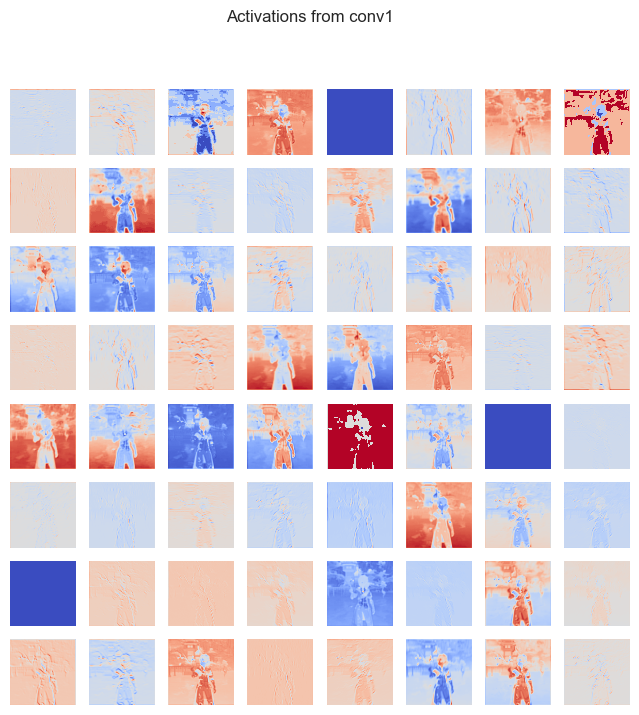

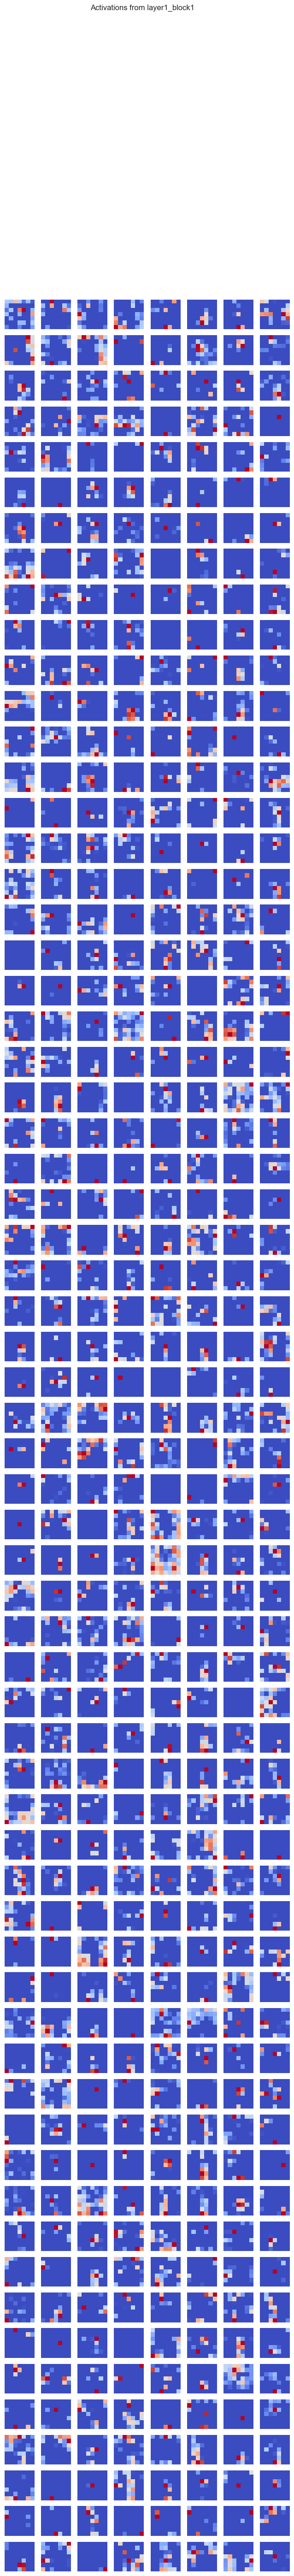

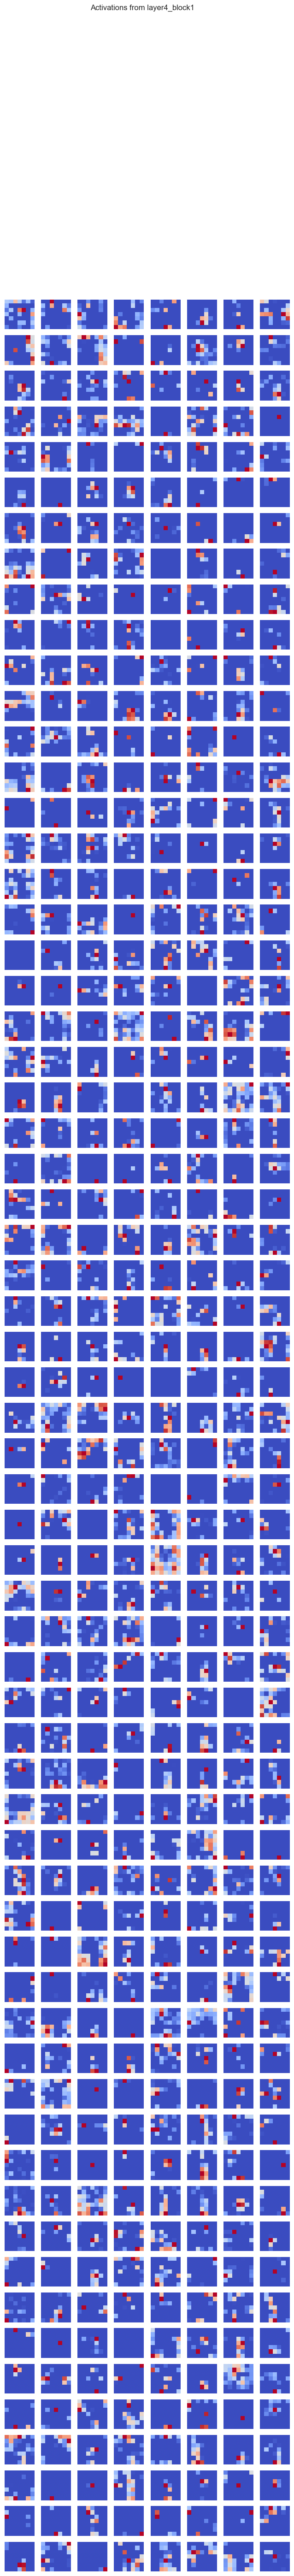

In [132]:
for name, activation in activations.items():
    # For convolutional layers, activation shape is (batch_size, num_channels, H, W)
    act = activation[0]
    act = act - act.min() # Почему нужно нормализовать?
    act = act / act.max()
    visualize_feature_maps(act, title=f'Activations from {name}')